# Journal Profiling Part 3: Funding

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [grants data ](https://docs.dimensions.ai/dsl/datasource-grants.html) for a list of researchers, so to enrich this list with funding-related metrics. 

This tutorial is the third of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the researchers impact metrics dataset previously extracted
* Query the grants API using the researchers IDs, to obtain their total grants and funding amount
* Enrich the original dataset with these new metrics  
* Build some simple visualizations in order to have a quick overview of the results 

In [20]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


Finally, let's set up a folder to store the data we are going to extract: 

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)

def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

### Load previously saved researchers data 

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `2_researchers_impact_metrics.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [3]:
researchers = pd.read_csv(FOLDER_NAME+"/2_researchers_impact_metrics.csv")

In [4]:
# TIP to speed this up I'm taking only the top 2000 researchers!
# for a full analysis, just comment out the next line
researchers = researchers[:2000]

In [5]:
# note the extra column will be dropped after re-running
researchers.head(5)

,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,77,Kari Stefansson,201.493506,248.818182,2021,NaN
1,ur.01277776417.51,51,Unnur Thorsteinsdottir,131.862745,201.666667,2021,NaN
2,ur.0641525362.39,42,Gonçalo R. Abecasis,223.714286,167.809524,2021,NaN
3,ur.011675454737.09,39,Cornelia M van Duijn,216.102564,303.179487,2021,NaN
4,ur.01264737414.70,39,Tõnu Esko,244.564103,339.923077,2021,NaN


## Adding another impact measure: funding 

We want to enhance the reseachers dataset by adding some funding information:

* total amount of funding for each researcher 
* total number of grants 
* funding end date (useful to understand who is going to publish soon)

### We'll have to do it in two steps


**1 Total grants and last grants year can be easy to extract using the 'researchers' source.** For example:

In [6]:
%%dsldf  
search researchers 
    where id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id+last_grant_year+total_grants]

Returned Researchers: 2 (total = 2)
Time: 0.52s


,id,last_grant_year,total_grants
0,ur.0723426172.10,2018,8
1,ur.01277776417.51,2020,1


**2 Aggregated funding needs to be extracted from the `grants` database.** For example:

> NOTE this kind of aggregate query will not return any data if a researcher that has no grants!


In [7]:
%%dsldf 
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 14
Time: 0.57s


,count,funding,id
0,8,17760368.0,ur.0723426172.10
1,2,0.0,ur.012662217132.90
2,1,0.0,ur.010520247252.54
3,1,0.0,ur.01121653260.31
4,1,0.0,ur.01127672147.84
5,1,0.0,ur.011316554452.18
6,1,0.0,ur.012167132327.75
7,1,0.0,ur.012237141052.77
8,1,0.0,ur.012455520474.57
9,1,2592940.0,ur.01274135317.46


## Next: full data for step 1

What we're gonna do 

1. loop over all researchers (400 at a time) 
2. extract the **tot grants** and **last grants year** information
3. collect all data into a single dataframe 
4. finally, add the data to our 'researchers' spreadsheet 



In [8]:
llist = list(researchers['researcher_id'])
VERBOSE = False
#
#
query = """search researchers 
                where id in {} 
            return researchers[id+last_grant_year+total_grants] limit 1000"""
#
#
out = []
for chunk in progress(list(chunks_of(list(llist), 400))):
    q = dsl.query(query.format(json.dumps(chunk)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df1 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df1))

  0%|          | 0/5 [00:00<?, ?it/s]

Researchers used to query:  2000
Researchers returned:  2000


Save the data so that we can use it later, and preview the results.

In [9]:
df1.head(10)

,id,last_grant_year,total_grants
0,ur.0777517431.61,2015.0,10
1,ur.07773763167.28,NaN,0
2,ur.0776707354.45,NaN,0
3,ur.07746151362.14,2017.0,7
4,ur.0773127601.34,NaN,0
5,ur.0772101217.51,NaN,0
6,ur.0770340363.50,2023.0,11
7,ur.0767751267.74,2025.0,10
8,ur.0767750151.59,2014.0,1
9,ur.0765447455.52,2017.0,8


## Next: full data for step 2

For this part we will do the following steps:

1. loop over all researchers, chunked in groups of 50
2. for each group, query grants matching those researchers IDs. Instead of returning grants data though, we **facet** on researchers and **aggregate funding information**
3. process the researchers data we got, so to keep only the journal authors we are interested in

**NOTE** since we are querying for grants, each query can return many more researchers than the ones we are asking for, as the co-authors of a grant are also matched

Example query:

In [10]:
%%dsldf  
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 14
Time: 0.57s


,count,funding,id
0,8,17760368.0,ur.0723426172.10
1,2,0.0,ur.012662217132.90
2,1,0.0,ur.010520247252.54
3,1,0.0,ur.01121653260.31
4,1,0.0,ur.01127672147.84
5,1,0.0,ur.011316554452.18
6,1,0.0,ur.012167132327.75
7,1,0.0,ur.012237141052.77
8,1,0.0,ur.012455520474.57
9,1,2592940.0,ur.01274135317.46


Here we 'chunk' using a lower number because each query will return more researchers than the ones we ask for (because we are querying 'grants' this time) 

In [11]:
llist = list(researchers['researcher_id'])
VERBOSE = False

#
#
query = """search grants 
            where researchers.id in {} 
           return researchers[id] aggregate funding limit 1000"""
#
#
out = []
for batch in progress(list(chunks_of(llist, 50))):
    q = dsl.query(query.format(json.dumps(batch)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df2 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df2))

  0%|          | 0/40 [00:00<?, ?it/s]

Researchers used to query:  2000
Researchers returned:  38726


Save to csv and preview the data

In [12]:
df2.head(10)

,count,funding,id
0,43,123777299.0,ur.011026120037.74
1,38,35429387.0,ur.010700366647.17
2,38,114643773.0,ur.013723776517.34
3,38,26808630.0,ur.015704744537.99
4,34,79909972.0,ur.01367711150.31
5,33,57010534.0,ur.016704245502.43
6,29,15551744.0,ur.01313145634.66
7,27,18617422.0,ur.010065171457.69
8,25,269879039.0,ur.01104262534.26
9,24,193563223.0,ur.011517303117.07


## Finally: let's merge the new data into the 'researchers-impact' table

In [13]:
#
# first let's replace all empty values with zeros
#

df1 = df1.fillna(0)
df2 = df2.fillna(0)

#
# helper functions 
#

def grants_and_year_from_id(researcher_id):
  "try/except to prevent some parsing errors."
  try:
    x = int(df1[df1['id'] == researcher_id]['total_grants'])
  except:
    x = 0
  try:
    y = int(df1[df1['id'] == researcher_id]['last_grant_year'])
  except:
    y = 0
  return (x, y)

def total_funding_from_id(researcher_id):
    """Since the bulk querying returned several rows for same researcher (due to various random combinations
    of researcher IDs lists in the query filters), we take the max value."""
    return df2[df2['id'] == researcher_id]['funding'].max()
    
#
# merge the results found into original researchers dataset
#

total_grants, last_grant_year, total_funding  = [], [], []

for i, row in progress(researchers.iterrows(), total=researchers.shape[0]):
    res_id = row['researcher_id']
    data = grants_and_year_from_id(res_id)
    total_grants.append(data[0])
    last_grant_year.append(data[1])
    total_funding.append(total_funding_from_id(res_id))

researchers['total_grants'] = total_grants
researchers['last_grant_year'] = last_grant_year
researchers['total_funding'] = total_funding
#
# finally..
#
print("=======\nResearchers total:",  len(researchers))
researchers.head(10)

  0%|          | 0/2000 [00:00<?, ?it/s]

Researchers total: 2000


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url,total_grants,last_grant_year,total_funding
0,ur.0723426172.10,77,Kari Stefansson,201.493506,248.818182,2021,NaN,8,2018,17760368.0
1,ur.01277776417.51,51,Unnur Thorsteinsdottir,131.862745,201.666667,2021,NaN,1,2020,NaN
2,ur.0641525362.39,42,Gonçalo R. Abecasis,223.714286,167.809524,2021,NaN,21,2023,78903893.0
3,ur.011675454737.09,39,Cornelia M van Duijn,216.102564,303.179487,2021,NaN,6,2023,11051128.0
4,ur.01264737414.70,39,Tõnu Esko,244.564103,339.923077,2021,NaN,10,2025,2073171.0
5,ur.012264440652.05,36,Jerome I. Rotter,176.555556,175.638889,2021,NaN,16,2025,161922027.0
6,ur.01247426430.47,36,Gudmar Thorleifsson,142.805556,164.694444,2021,NaN,0,0,NaN
7,ur.01317433110.75,36,Caroline Hayward,256.166667,311.166667,2021,NaN,4,2024,9246651.0
8,ur.0637651205.48,35,Daniel F Gudbjartsson,124.057143,211.142857,2021,NaN,0,0,NaN
9,ur.01174076626.46,34,André G Uitterlinden,228.058824,274.558824,2021,NaN,1,2014,0.0


Save the data / download it

In [14]:
save(researchers, "3_researchers_impact_metrics_and_funding.csv")

## Couple of Dataviz

In [15]:
temp1 = researchers.sort_values(by=["total_funding"], ascending=False)[:100]
temp2 = researchers.sort_values(by=["last_grant_year"], ascending=False)[:200]

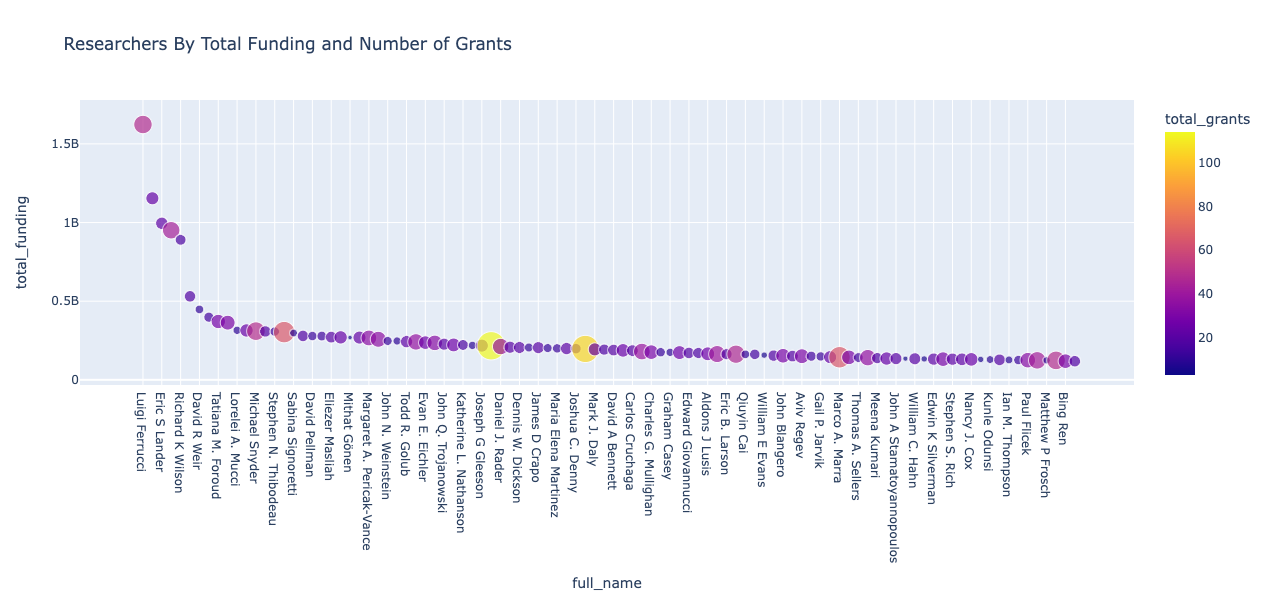

In [16]:
px.scatter(temp1, 
           x="full_name", y="total_funding", 
           hover_name="full_name", 
           size="total_grants", 
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           height=600,
           title="Researchers By Total Funding and Number of Grants")

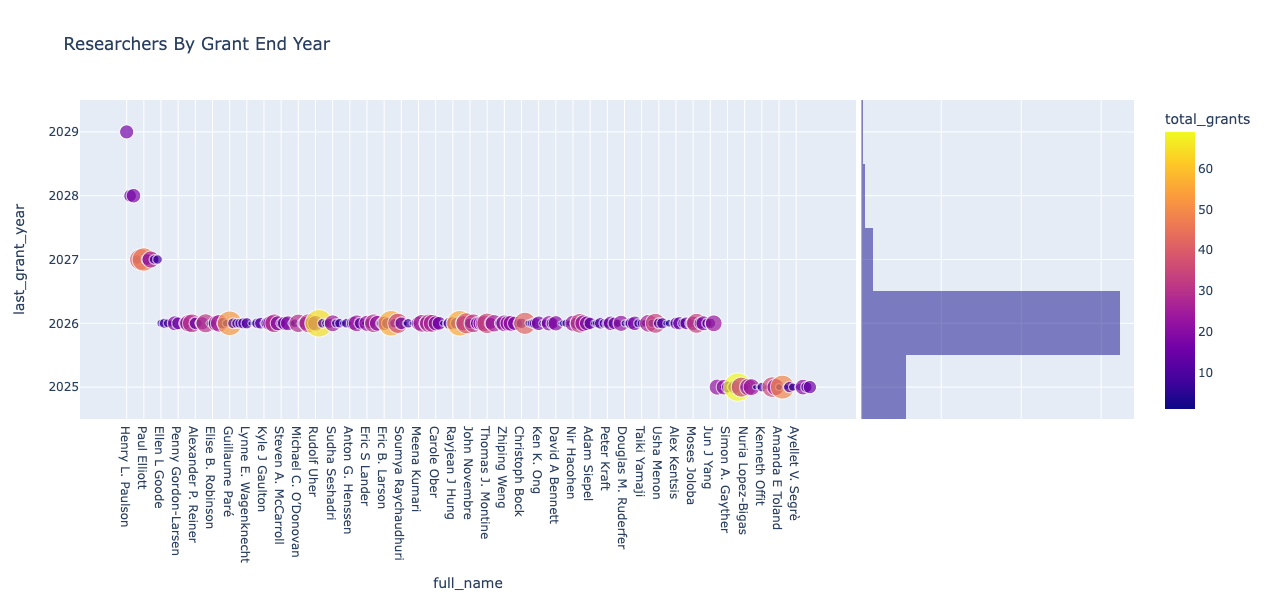

In [17]:
px.scatter(temp2, 
           x="full_name", y="last_grant_year", 
           hover_name="full_name", 
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           height=600,
           marginal_y="histogram",  title="Researchers By Grant End Year")

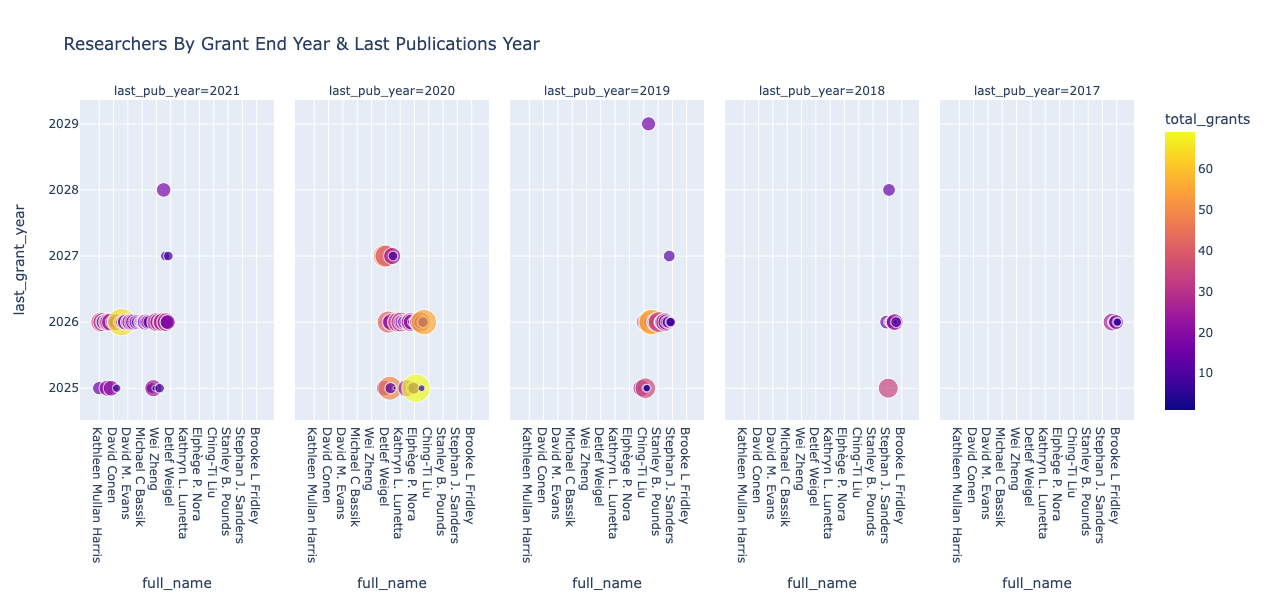

In [18]:
px.scatter(temp2.sort_values("last_pub_year", ascending=False), 
           x="full_name", y="last_grant_year", 
           hover_name="full_name",  
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           facet_col="last_pub_year", 
           height=600,
           title="Researchers By Grant End Year & Last Publications Year")

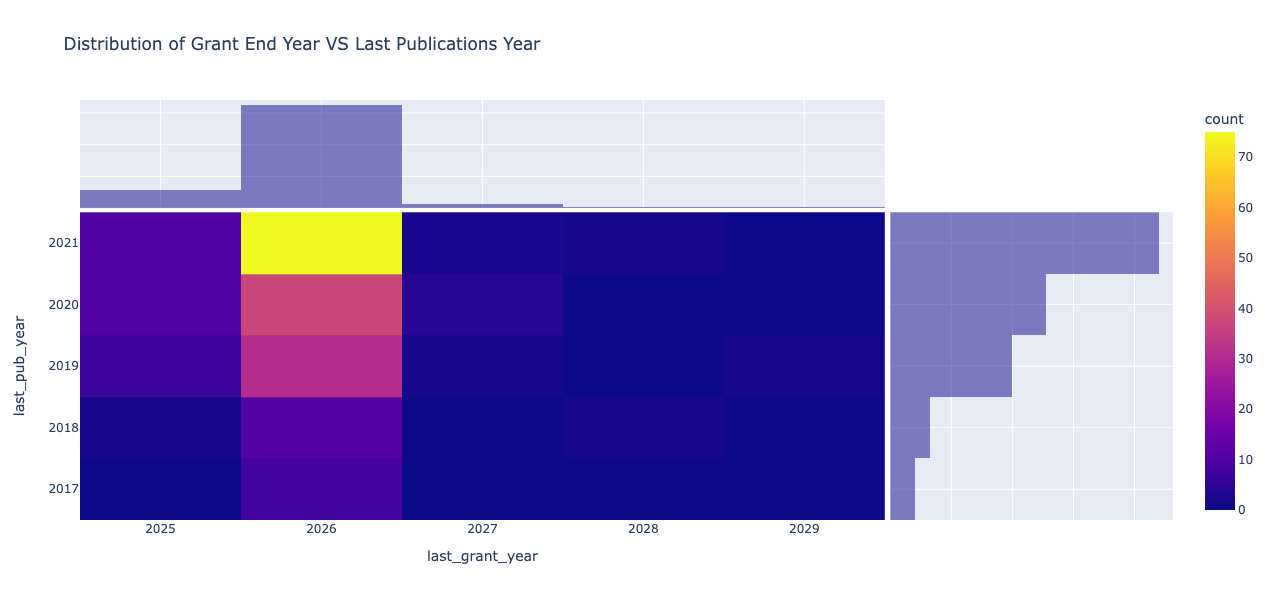

In [19]:
px.density_heatmap(temp2, 
                   x="last_grant_year", y="last_pub_year", 
                   marginal_x="histogram", marginal_y="histogram", 
                   height=600,
                   title="Distribution of Grant End Year VS Last Publications Year")